<a href="https://colab.research.google.com/github/weymouth/MarineHydro/blob/master/notebooks/panel_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Potential flow panel method 🚢

A panel method is a numerical approach to constructing potential flows around engineering shapes such as a wing or ship hull. Panel methods used in industry are typically 3D, but we will use a 2D approach which is sufficient for strip theory calculations.

## Potential and velocity of panel source 🚰

The 2D vesion of a panel is a line _segment_. In general this segment will run from some point $(x_i,y_i)$ to $(x_{i+1},y_{i+1})$ and will have a potential flow singularity distributed over it. 

For example, a 2D source potential is proportional to

$$ G(x,y,x_s,y_x) = \log(r_s) = \frac 12 \log(r_s^2) $$

where $r_s^2 = (x-x_s)^2+(y-y_s)^2$ is the square-distance from the point $(x_s,y_s)$ on the segment to a point $(x,y)$ in space. $G$ is called a [Green's function](https://en.wikipedia.org/wiki/Green%27s_function) and you can think of it as the building block for the panel method. 

The potential of the panel is the integrated superposition of $G$ along the segment, ie

$$ \phi_i(x,y) = q_i \int_{s_i}^{s_{i+1}} G(x,y,x_s,y_s) ds = q_i F_i^\phi(x,y)$$

where $q_i$ is the source strength per segment length. We will assume the strength is constant along each panel, allowing us to pull it out of the integral. The function $F_i^\phi$ is the potential **influence function**, the potential induced by segment $i$ per unit strength.

The potential flow velocity is the gradient of this potential (as usual) and since the $q_i$ is a constant, we can pull it outside the derivative

$$ \vec u_i = \vec\nabla\phi_i = q_i\vec\nabla F^\phi_i=q_iF^{\vec u_i}\ ,\quad F^{\vec u_i} = \left[\frac{\partial F^\phi_i}{\partial x},\frac{\partial F^\phi_i}{\partial y}\right]$$

which defines the influence functions for the velocity $\vec u$.

We will approximate the integral with a [Gaussian-quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature#/media/File:Comparison_Gaussquad_trapezoidal.svg) and the derivatives with [finite differences](https://en.wikipedia.org/wiki/Finite_difference#/media/File:Finite_difference_method.svg).

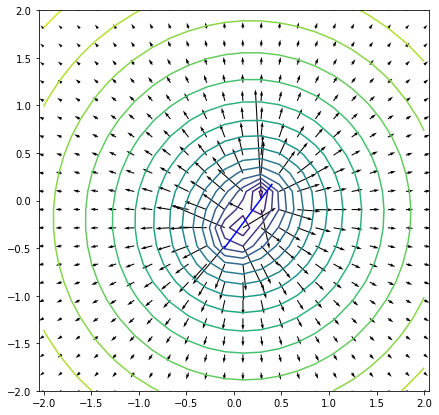

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def source(x,y,xs,ys): return 0.5*np.log((x-xs)**2+(y-ys)**2)

GAUSS2 = 0.5*(1+np.sqrt(1/3)) # gaussian-quadrature sample point
def potential(x,y,x0,y0,x1,y1,G=source,args=()):
  "Gaussian quadrature estimate of the potential influence function"
  def dG(s): return G(x,y,x0*(1-s)+x1*s,y0*(1-s)+y1*s,*args)
  h = np.sqrt((x1-x0)**2+(y1-y0)**2)
  return 0.5*h*sum(dG(s) for s in [GAUSS2,1-GAUSS2])

def velocity(x,y,x0,y0,x1,y1,G=source,args=(),eps=1e-6):
  "Finite difference estimate of the velocity influence function"
  def phi(x,y): return potential(x,y,x0,y0,x1,y1,G,args)
  return np.array(((phi(x+eps,y)-phi(x-eps,y))/(2*eps),  # dphi/dx
                   (phi(x,y+eps)-phi(x,y-eps))/(2*eps))) # dphi/dy

# Example segment
x0,y0 = -.1,-0.5
x1,y1 = 0.4,.17

# Visualize the flow
XY = np.meshgrid(np.linspace(-2,2,22),np.linspace(-2,2,22))
UV = velocity(*XY, x0, y0, x1, y1)
Phi = potential(*XY, x0, y0, x1, y1) 

# Plot it up
plt.figure(figsize=(7,7))
plt.quiver(*XY, *UV)
plt.contour(*XY, Phi, 20)
plt.plot([x0,x1],[y0,y1],c='b')
plt.axis('equal');

The resulting flow is the same as a source flow when $r \gg ds$. However, the velocity is finite and smooth near the panel. This "well behaved" velocity makes distributed potentials a good choice for numerical methods.

> **Note:** Using numerical approximations makes our `potential` and `velocity` functions **re-usable**. We have used a source singularity, but we could use some other Green's function if we want. _Different singularities are good for building different types of flows_. [This interactive webapp](https://weymouth.github.io/fluid-dynamics/vortexpanel/index.html) uses vortex segments to predict the flow and forces over a thin wing, and at the bottom of this notebook we will use a wave singularity for free surface flows.

---

## Superposition 💧➕💧➕💧= 💦

The next step is to link multiple panels together to form a geometry. The total potential and velocity will simply be the superposition (sum) of each 
of source panels given above

$$\phi=\sum_i \phi_i=\sum_i q_i F_i^\phi\ ,\quad \vec u = \sum_i \vec u_i=\sum_i q_i F_i^{\vec u}.$$ 

Let's define a set of $N$ panels by connecting $N+1$ points $x_0\ldots x_N$ and $y_0\ldots y_N$. Then the Python code for the potential or velocity is a simply `sum` over `i in range(N-1)`. 

Here's a superposition version of the plotting code above, and a test on a few panels.

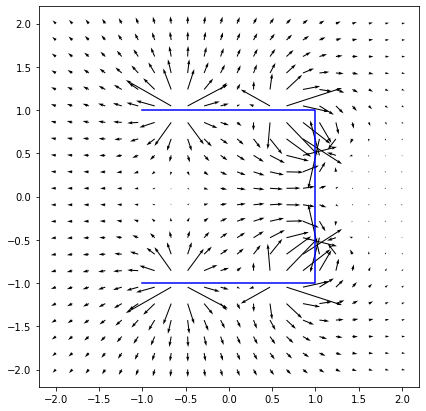

In [2]:
def plot_flow(x,y,q,XY,G=source,args=(),size=(7,7),ymax=None):
  # Loop through segments, superimposing the velocity
  def uv(i): return q[i]*velocity(*XY, x[i], y[i], x[i+1], y[i+1], G, args)
  UV = sum(uv(i) for i in range(len(x)-1))

  # Create plot
  plt.figure(figsize=size)
  ax=plt.axes(); ax.set_aspect('equal', adjustable='box')

  # Plot vectors and segments
  Q = plt.quiver(*XY, *np.real(UV))
  if np.iscomplexobj(UV):
    Q._init() 
    plt.quiver(*XY, *np.imag(UV), scale=Q.scale, color='g')
  plt.plot(x,y,c='b')
  plt.ylim(None,ymax)

plot_flow([-1,1,1,-1],[-1,-1,1,1],[1,-1,1],XY)

Excellent! We can now plot the flow induced by a set of panels. Move around the points and change the strength `q` to see how the flow changes.

> **Note:** The velocity isn't _that_ smooth since we've only approximated the integral with two samples (you can see where they are). This will be less of a problem when we use smaller panels. Lets define a function to create `N` panels in the shape of an ellipse.

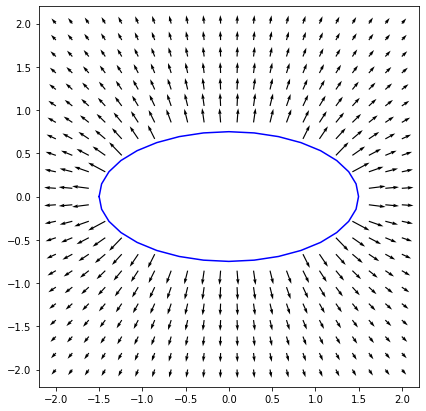

In [3]:
def ellipse(N,a=1,b=1,theta1=np.pi):
  "x,y arrays around an elliptical arc"
  theta = np.linspace(-np.pi,theta1,N+1) # N+1 points for N panels
  return a*np.cos(theta),b*np.sin(theta)

def mask_grid(x,y,mask):
  "delete mesh points where mask is true"
  def delete(a): return np.ma.masked_array(a,mask(x,y)).compressed()
  return np.array((delete(x),delete(y)))

# geometry
rx,ry = 1.5,0.75
x,y = ellipse(32,rx,ry)
EXY = mask_grid(*XY,mask=lambda x,y: (x/rx)**2+(y/ry)**2<1)

q = np.ones_like(x) # we don't know q yet!
plot_flow(x,y,q,EXY)



## Linear system 🚣 ✖ ⚡ = 🚤

The figure above assumes $q_i=1$, but we can get different flows around the same geometry by adjusting this strength array. But how can we set $q_i$ to, say, compute the flow over an ellipse moving to the left?

The Lapace equation $\nabla^2 \phi = 0$ is satisfied automatically for any set of panel strengths so we need to determine $q_i$ another way. 

Instead the strength is determined using the body boundary
> **Body boundary condition**: The total normal velocity induced by all the panels must equal the normal body velocity.
$$\sum_i \vec u_i\cdot \hat n = \vec U \cdot \hat n \quad\text{on the body}$$ 
where $\hat n$ is the body normal and $\vec U$ is the body velocity. 

This equation can be applied at every panel $j$. Substitution gives

$$\sum_i q_i F^{\vec u}_i(x_j,y_j)\cdot \hat n_j = \sum_i a_{ji} q_i  = \vec U \cdot \hat n_j \quad\text{on the body}$$

where $a_{ji}$ is the normal velocity influence of panel $i$ on panel $j$. 

This is a system of linear equations which we can write in the familiar matrix form:
$$ \mathbf{A q} = \mathbf{b}$$
where $b_j=\vec U \cdot \hat n_j$ and bold face indicates matrices and vectors. This linear system of equations can be solved for $q_i$ using [`numpy.linalg.solve`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html).

**Aside:** The velocity induced by a panel on itself ($a_{ii}$) isn't accurately computed using the `velocity` influence function, so I've added this contribution manually using $\mathbf{A}=\mathbf{A}+\pi\mathbf{I}$, where $\mathbf{I}$ is the identity matrix.

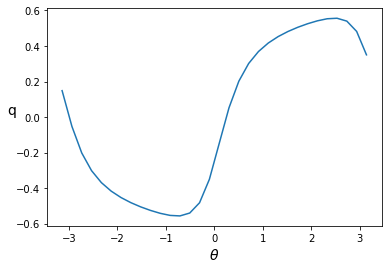

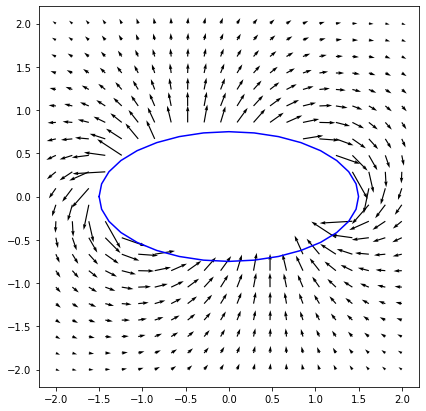

In [4]:
def properties(x0, y0, x1, y1):
  "properties of a line segment"
  sx, sy = x1-x0, y1-y0         # segment vector
  xc, yc = x0+0.5*sx, y0+0.5*sy # segment center 
  h = np.sqrt(sx**2+sy**2)      # segment length
  nx, ny = sy/h, -sx/h          # segment unit normal
  return xc, yc, nx, ny, h

def construct_A(x,y,G=source,args=(),aii=np.pi):
  "construct the velocity influence matrix"
  # influence of panel i on the normal velocity at each panel center
  xc, yc, nx, ny, _ = properties(x[:-1], y[:-1], x[1:], y[1:])
  def u_n(i):
    u,v = velocity(xc,yc,x[i],y[i],x[i+1],y[i+1],G,args)
    return u*nx+v*ny

  # construct matrix
  A = np.array([u_n(i) for i in range(len(yc))]).T
  A += aii*np.eye(len(yc)) # add panel self-influence
  return A,nx,ny

x,y = ellipse(32,rx,ry)
A,nx,ny = construct_A(x,y)
b = -1*nx+1*ny # change the motion direction with this
q = np.linalg.solve(A,b)
plt.plot(np.linspace(-np.pi,np.pi,len(q)),q)
plt.xlabel(r'$\theta$',size=14);plt.ylabel('q',rotation=0,size=14)
plot_flow(x,y,q,EXY)

Awesome! We can now solve for the potential flow around any set of moving panels!!

---

## Added mass 🐙

One of the most important applications of potential flow is the estimation of added mass due to body oscillations.  The oscillation displacement is written as

$$\vec \xi = |\xi_k| \cos(\omega t) \hat e_k $$
where $|\xi_k|,\omega$ are the oscillation amplitude and frequency and $k=2,3$ indicates motion in sway and heave.

> **Note:** Since strip theory is typically used to describe motions in the $y,z$ plane, we will switch to that coordinate system - but this doesn't change _anything_ in the code above.

There are two steps to predicting the added mass: 

**1. Determine the the potential for motion in direction $k$**

The body velocity $\frac{\partial}{\partial t}{\vec\xi}$ determines the potential via the $u_n=U_n$ boundary condition. If we define the unsteady potential as

$$\phi(t) = -|\phi_k||\xi_k|\omega\sin(\omega t) $$
where $|\phi_k|$ is the potential _per motion velocity_, then substituting the potential and body velocity into the boundary condition gives

$$ -\omega\sin(\omega t) |\xi_k| \left(\frac{\partial |\phi_k|}{\partial n} -n_k\right) = 0.$$
Since the sine isn't always zero, the term in parenthesis must be set to zero. 

> **Note:** This is the same body boundary condition we used in the steady case. 

Therefore, defining $|\phi_k| = \sum_i q_{k,i} F_i^\phi$ we can use the same normal velocity influence matrix to solve for the source strength of each panel due to body oscillations in direction $k$ as
$$ \mathbf{A}\mathbf{q}_k = \mathbf{n}_k$$

**2. Integrate the pressure to determine the force**

The added mass force is the integrated pressure due 
to the unsteady potential

$$ \vec f = \rho \oint \frac{\partial\phi}{\partial t} \hat n ds$$

Substiting $\phi$ gives the $l$-component of the added mass force as

$$ f_l = \sum_{k=2}^3 \rho \oint -\omega^2\cos(\omega t)|\phi_k||\xi_k|\ n_l\ ds = -\sum_{k} \ddot\xi_k m_{kl}$$
where $\ddot\xi_k=-\omega^2 |\xi_k|\cos(\omega t)$ is the body acceleration and $m_{kl}$ is the added mass matrix
$$ m_{kl} = -\rho\oint |\phi_k| n_l ds = -\rho\sum_j |\phi_{k,j}| n_{l,j} h_j . $$

Substituting the equation for $|\phi_k|$ gives
$$ m_{kl} = -\rho\sum_j\sum_i q_{k,i} F_i^\phi(x_j,y_j) n_{l,j} h_j $$

That's it. Solve for each $q_k$ as before, and then plug it into double summation.
We can **validate** our numerical method by computing the added mass of an ellipse with semi-axis lengths $r_2,r_3$ and compare it to the exact solution $m_{22} = \rho \pi r_3^2,\ m_{33}=\rho\pi r_2^2$. 

In [5]:
def added_mass(y,z,G=source,args=(),rho=1):
  "Compute the added mass matrix"
  # strength due to y,z motion
  A,ny,nz = construct_A(y,z,G,args)
  qy = np.linalg.solve(A,ny)
  qz = np.linalg.solve(A,nz)

  # potential due to y,z motion (times panel width)
  yc,zc,_,_,h = properties(y[:-1], z[:-1], y[1:], z[1:])
  hF = [h*potential(yc,zc,y[i],z[i],y[i+1],z[i+1],G,args) for i in range(len(yc))]
  phiy,phiz = hF@qy,hF@qz # potential influence matrix times strength

  # sum over panels 
  return -rho*np.matrix([[phiy@ny,phiy@nz],[phiz@ny,phiz@nz]])

# test add_mass
def err(m,r): return 100*(m/(np.pi*r**2)-1) 
print('    |   % error\n N  |  m22 |  m33 ')
rx,ry = 1.5,0.75
for N in 2**(np.arange(6)+4):
  m = added_mass(*ellipse(N,rx,ry))
  print(f'{N:3} | {err(m[0,0],ry):.2f} | {err(m[1,1],rx):.2f}')

    |   % error
 N  |  m22 |  m33 
 16 | 1.88 | -2.73
 32 | 1.48 | -0.74
 64 | 0.87 | -0.22
128 | 0.47 | -0.07
256 | 0.24 | -0.02
512 | 0.12 | -0.01


The error is less than 1% for the added mass coefficients using only 32-64 panels and **converges** to zero with more panels. 

> **Note:** The error goes down by $\times 2$ when the number of panels increases by $\times 2$. Therefore the error is proportional to the panel size, $\varepsilon\sim h$, which is called _linear_ convergence. 

---

## Free surface potential 🌊

The method above can predict the potential flow and added mass around any 2D shape (or shapes...) completely immersed in air or water. However, when an object moves near the free surface it generates waves, and this changes the flow and forces significantly. 

**We need to modify the oscillating source potential used above and add the potential flow waves which it generates.**  Here is the potential, taken from [this modern paper](https://www.researchgate.net/profile/Ed-Mackay/publication/344610701_Calculation_of_the_two-dimensional_free_surface_Green_function/links/5f84519f299bf1b53e20e1f2/Calculation-of-the-two-dimensional-free-surface-Green-function.pdf):

$$ G(x,y,x_s,y_s) = \log(r_s)-2\pi \imath e^Z-2f(Z) $$

There are three terms:

1. The first term is the **oscillating source** defined as before.

2. The second term is the **propagating wave** written using complex variables. The standard wave potential is 
$$ \phi = \frac{|\eta|g}{\omega} e^{Ky}\cos(Kx-\omega t+\Phi) $$
where $\omega$ is the oscillation frequency, $|\eta|,\Phi$ are the wave amplitude and phase and $K=\omega^2/g$ is the deep water wave number. In complex variables we have $e^{\imath\theta} = \cos\theta+\imath\sin\theta$, where $\imath=\sqrt{-1}$. Therefore we can write
$$ \phi = \text{Re}\left[|\zeta| e^{K(y+\imath x)}e^{-\imath\omega t}\right] $$
where $|\zeta|$ is a complex amplitude that includes the phase relative to the motion. The wave term in the equation above is a modification of this basic idea defining $Z=K(y+y_s+\imath(x-x_s))$ and scaling the amplitude relative to the oscillating source. 

3. Finally, the last term is a **standing wave** potential that ensures the oscillating souce satisfies the free surface boundary condition
$$ K\phi-\frac{\partial\phi}{\partial y} = 0 \quad\text{on}\quad y=0$$

Let's look at the velocity field induced by a single source panel near the free surface.

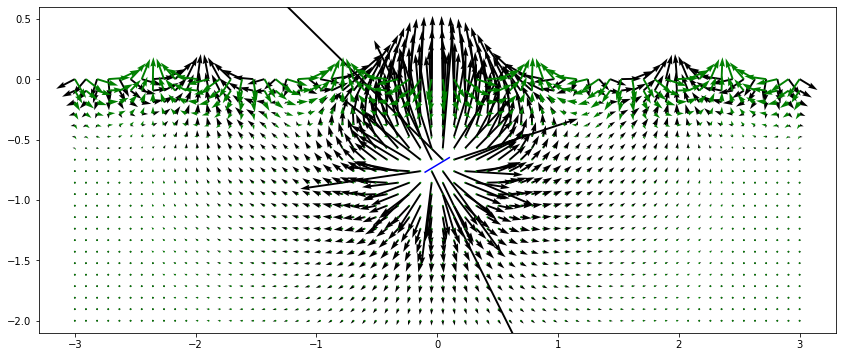

In [6]:
from scipy.special import exp1

def wave_source(x,y,xs,ys,K):
  "Source plus generated free surface waves"
  r2 = (x-xs)**2+(y-ys)**2   # source square-distance
  Z = K*(y+ys+1j*abs(x-xs))  # wave number scaled complex vector
  eZ = np.exp(Z)             # propagating wave potential
  # standing wave potential
  fZ = 2*np.real(eZ*exp1(Z))+np.log(np.abs(Z))
  return 0.5*np.log(r2)-2j*np.pi*eZ-fZ

YZ = np.meshgrid(np.linspace(-3,3,66),np.linspace(-2,0,22))
K = 4

plot_flow([-.1,.1],[-.77,-0.65],[1],YZ,wave_source,(K,),size=(16,6),ymax=0.6)

The black arrows show the flow velocity in phase with the body velocity (the part with $\sin\omega t$ like before). Now that we have free surface waves, we also have velocity out of phase with the body ($\cos\omega t$), shown in the green arrows. 

This is easier to understand using a movie!

> **Note:** It takes a while for Python to generate the videos, so I've commented those lines out. Uncomment and play around with the flows in the following cells as much as you like.

In [7]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def wave_video(x,y,q,XY,G=wave_source,args=(4,),size=(16,6)):
  # Get complex velocity
  def uv(i): return q[i]*velocity(*XY, x[i], y[i], x[i+1], y[i+1], G, args)
  UV = sum(uv(i) for i in range(len(x)-1))

  # Plot flow and segments
  fig, ax = plt.subplots(1,1,figsize=size)
  Q = ax.quiver(*XY, *UV)#, pivot='mid')
  ax.plot(x,y,c='b')
  ax.set_ylim(None,0.5)
  ax.set_aspect('equal', adjustable='box')
  plt.close()

  # run through a wave period
  def update_quiver(num, Q):
      Q.set_UVC(*np.real(UV*np.exp(-2j*np.pi*num/101)))
      return Q,

  # create the animation
  return FuncAnimation(fig, update_quiver, fargs=(Q,), interval=50)

# anim = wave_video([-.1,.1],[-.77,-0.65],[1],YZ)
# HTML(anim.to_html5_video())

[![Link to video](http://i3.ytimg.com/vi/3DSdek0stHM/hqdefault.jpg)](https://youtu.be/3DSdek0stHM)

Looks good. The source, standing wave above it, and the radiating waves on either side are all visible. 

> **Note:** Now that you've seen the video, go back and look at the plot above. The black and green arrows are like snapshots of the video at the start and quarter of the way through a cycle. While the movie is certainly easier to digest, it's important to realize the complex amplitude $|\phi_k|$ has all the information needed to make the movie.

---

## Solving for free surface potential flows and forces 🛥

> **Note:** The plots above use the original `velocity` function, they just apply the new `wave_source` singularity instead of the `source` singularity. Similarly, the `potential` `construct_A` and `added_mass` functions can all by applied to free surface flows without modification!

This is why writing re-usable functions is so powerful. Let's use our new Green's function to produce the flow around a semi-circular ship section in sway.

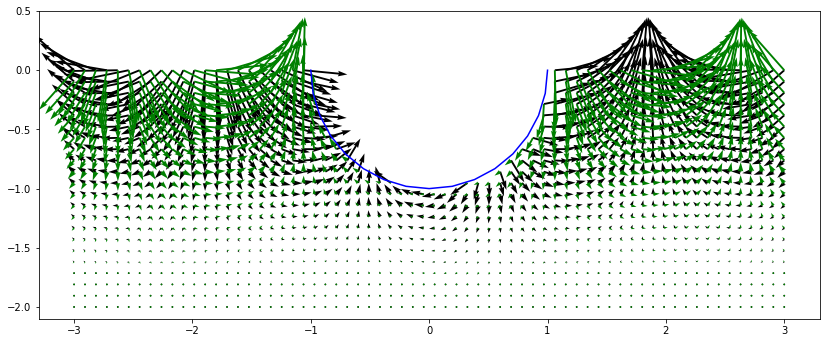

In [8]:
y,z = ellipse(16,theta1=0)
circleYZ = mask_grid(*YZ,mask=lambda y,z: y**2+z**2<1)
K=2
A,ny,nz = construct_A(y,z,wave_source,(K,))
q = np.linalg.solve(A,ny)
plot_flow(y,z,q,circleYZ,wave_source,(K,),size=(14,6),ymax=0.5)
# anim = wave_video(y,z,q,circleYZ,wave_source,(K,))
# HTML(anim.to_html5_video())

That's amazing! You can clearly see the waves radiating away from the ship hull in either direction. When the ship moves to port, it forms a new crest on the port side, and vis versa!

Finally let's get the added mass:

In [9]:
ma = added_mass(y,z,wave_source,(K,))
print(np.array_str(ma, precision=3, suppress_small=True))

[[ 0.289+0.626j -0.   -0.j   ]
 [-0.   -0.j     1.109+0.232j]]


Look carefully at this result because two important things have changed since we moved into free surface flows
1. **The "added mass" has a real and complex part!** This is because some of the force is in-phase with acceleration (like before) and some is in-phase with velocity. The first part is the sectional added mass $A_{kl}$ and the second part is the wave damping $B_{kl}$. The damping is due to the energy leaving the system in the radiating waves, which is why the damping is zero when there is no free surface. 
1. **The added mass and damping depend on the motion direction and wave number!** A fully submerged circle of radius $R$ has $m_{22}=m_{33}=\rho \pi R^2$ independant of the oscillation frequency. But the standing and radiating waves must satisfy the free surface boundary condition, which depends on $K$, and their amplitude and phase depends on the direction of motion $k$. Therefore the added mass and damping matrices are functions of $K$ and $k$ as well.

Let's plot these coefficients

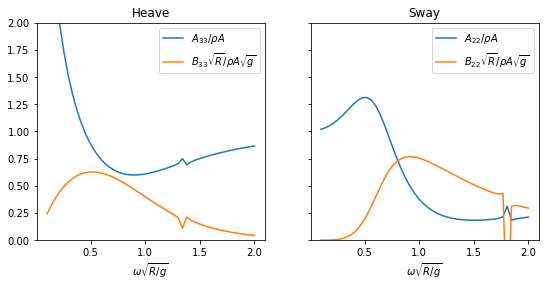

In [10]:
def force_coeffs(y,z,omega):
  ma = added_mass(y,z,wave_source,(omega**2,))
  rhoA = 0.5*np.pi
  return (np.real(ma[0,0])/rhoA,omega*np.imag(ma[0,0])/rhoA, #22
          np.real(ma[1,1])/rhoA,omega*np.imag(ma[1,1])/rhoA) #33

def force_plots(y,z,omega):
  A22,B22,A33,B33 = np.vectorize(lambda o: force_coeffs(y,z,o))(omega)

  f, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,4))
  plt.ylim(0,2)
  axes[0].set_title('Heave')
  axes[0].plot(omega,A33,'C0',label=r'$A_{33}/\rho A$')
  axes[0].plot(omega,B33,'C1',label=r'$B_{33}\sqrt{R}/\rho A\sqrt{g}$')
  axes[1].set_title('Sway')
  axes[1].plot(omega,A22,'C0',label=r'$A_{22}/\rho A$')
  axes[1].plot(omega,B22,'C1',label=r'$B_{22}\sqrt{R}/\rho A\sqrt{g}$')
  for ax in axes:
    ax.set_xlabel(r'$\omega\sqrt{R/g}$');ax.legend()
  plt.show()

omega = np.linspace(0.1,2)
y,z = ellipse(32,theta1=0)
force_plots(y,z,omega)

> **Note:** There are a couple little blips in our results where the influence matrix is not invertible. There are due to a resonance *inside* the geometry - and can safely be ignored.

Here are some experimental and analytic results for the added mass and damping on a semi-circle from [Vugts 1968](https://content.iospress.com/download/international-shipbuilding-progress/isp15-167-02?id=international-shipbuilding-progress%2Fisp15-167-02). 

| Heave| Sway|
|-|-|
|![heave](https://drive.google.com/uc?export=view&id=1JYMgqOeW_UEGjXzq1VrbZ5_HQXsh3ayI) | ![sway](https://drive.google.com/uc?export=view&id=19P67Q0zPyW_yquO_37lOhHZEFMJlnNiV)|


Our results match the analytic results in the paper really well. This validates our free surface force predictions!

The potential flow methods both match the experiments nicely other than the zero frequency heave added mass. Zero frequency heave is not linear - and so linear potential flow can't predict it.

---

## Multiple geometries ⛵⛵

The functions above only compute the flow and forces around a single shape - they take in **one** `x,y` array pair. How can we compute the flow induced by more than one shape, like a multi-hull ship? Here are some ideas:

1. *Superposition:* Can we define the geometries, solve for each flow separately, and then add the flow and forces together? 

No. If we solve for the flows separately, we will miss the influence of the bodies on each other. When we add them up, the body BC won't be satisfied and so the flow and forces will be wrong.

2. *Concatenation:* Can we stack all the body arrays together, and then solve for the flow?

This approach includes the influence of each body on the other, but it will also create fake panels linking the bodies together. We need to zero the influence of those non-panels to use this approach - as I've done below.

3. *Images:* Can we apply the method of images to reflect the geometry across the $y$ axis?

Yes, and this is the classic approach (since it play nice with analytic models) but there are some caveats. Importantly, this only works when you have a plane of symmetry! So you can't use this to model two independent boats - even if the hulls are identical, their motions won't be. 

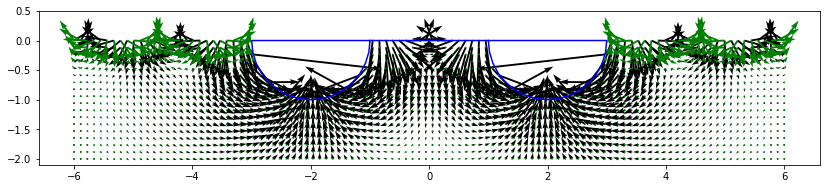

In [11]:
def circle_cat(N,g):
  ya,za = ellipse(N//2,theta1=0)
  yb,zb = ellipse(N//2,theta1=0)
  ya += 1+g
  yb -= 1+g
  return np.append(ya,yb),np.append(za,zb),[N//2]

def zero_influence(A,nx,ny,blank):
  for i in blank:
    A[i,:] = np.zeros(len(nx)); A[i,i] = 1
    nx[i] = 0; ny[i] = 0
  return A,nx,ny

N,K,gap = 32,4,1
y,z,blank = circle_cat(N,gap)
catYZ = np.meshgrid(np.linspace(-6,6,108),np.linspace(-2,0,18))
catYZ = mask_grid(*catYZ,mask=lambda y,z: (abs(y)-1-gap)**2+z**2<1)
A,ny,nz = zero_influence(*construct_A(y,z,wave_source,(K,)),blank)
q = np.linalg.solve(A,nz)
plot_flow(y,z,q,catYZ,wave_source,(K,),size=(14,6),ymax=0.5)
# anim = wave_video(y,z,q,catYZ,wave_source,(K,),size=(14,6))
# HTML(anim.to_html5_video())

Look at the wave in the center of the plot, between the two circles. Since the arrows are all black instead of green, there is no traveling wave - only a standing wave caught between the hulls. This is important for catamaran seakeeping predictions.